<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: MIRI view outlier_detection

<span style="color:red"> **Instruments Affected**</span>: e.g., FGS, MIRI, NIRCam, NIRISS

### Table of Contents


<div style="text-align: left"> 
    
<br> [Introduction](#intro)
<br> [JWST CalWG Algorithm](#algorithm)
<br> [Defining Terms](#terms)
<br> [Test Description](#description)
<br> [Data Description](#data_descr)
<br> [Imports](#imports)
<br> [Loading the Data](#data_load)
<br> [Run the Pipeline](#pipeline)
<br> [Perform Tests or Visualization](#testing) 
<br> [About This Notebook](#about)
<br>    

</div>

<a id="intro"></a>
# Introduction

This notebook allows visual inspection of a set of dithered images that are combined as part of calwebb_image3. The notebook will take a set of four simulated images, starting with the uncal format files that are the output of MIRISim. These images will have a randomized location for about 50 point sources and no extended sources.

These data files will be processed through calwebb_detector1, calwebb_image2 and calwebb_image3 and the output *i2d data file will be inspected. Past versions of the pipeline had the background subtracted twice, so the background levels were strongly negative, and other versions have had the background pixels wrongly flagged by outlier_detection. Part of this notebook is simply a visual inspection to be sure there is nothing obviously wrong with the output. While this notebook will look at the output of calwebb_image3 as a whole, the main task is to find where outlier_detection is incorrectly flagging pixels.

This notebook also inserts 'cr hits' at various random locations in each cal image (output of calwebb_image2), before running them through calwebb_image3. This notebook then tests whether the cr hits are correctly flagged as outliers by the outlier_detection step. There is also a visual comparison between the combined data with and without outlier_detection being performed to see if the output image has fewer artifacts in the version with outlier_detection.

> Pipeline documentation: https://jwst-pipeline.readthedocs.io/en/latest/jwst/outlier_detection/main.html

> Pipeline code: https://github.com/spacetelescope/jwst/tree/master/jwst/outlier_detection

[Top of Page](#title_ID)

<a id="algorithm"></a>
# JWST CalWG Algorithm

The outlier detection algorithm is defined in the confluence page listed here. It is used to reject outlier pixels found when comparing multiple dithered images together. Images are compared in overlapping regions and any pixel that seems to be an outlier (based on iterative sigma clipping) can be flagged and rejected from any combined set or mosaic of images.

> https://outerspace.stsci.edu/display/JWSTCC/Vanilla+Outlier+Detection


[Top of Page](#title_ID)

<a id="terms"></a>
# Defining Terms

Here are some of the terms that will be used in this notebook.

JWST: James Webb Space Telescope

MIRI: Mid-Infrafred Instrument

MIRISim: MIRI data simulator


[Top of Page](#title_ID)

<a id="description"></a>
# Test Description

This test takes a set of simulated images (at different dithered positions) and proceses them through all three stages of the Imager pipeline: calwebb_detector1, calwebb_image2, and calwebb_image3. A set of random pixels have added simulated 'cr hits' and this notebook checks that those pixels are properly flagged as outliers. The tests being run here also look at the output of the full image3 pipeine (the combined i2d data), check that the source_catalog output catalog marks the locations of our point sources, and checks on the number of pixels that are flagged in the outlier_detection step to be sure that the step is not flagging too many pixels. There is also a comparison between the images run through calwebb_image3 with and without outlier_detection performed to see if the outliers were detected and removed from the image as they should be with outlier_detection.

[Top of Page](#title_ID)

<a id="data_descr"></a>
# Data Description

The set of data used in this particular test were created with the MIRI Data Simulator (MIRISim). The simulator created four imaging mode files, one exposure each at four different dither positions, using the specified filter. There are approximately 50 point sources scattered through the images.


[Top of Page](#title_ID)

<a id="tempdir"></a>
# Set up Temporary Directory
The following cell sets up a temporary directory (using python's `tempfile.TemporaryDirectory()`), and changes the script's active directory into that directory (using python's `os.chdir()`). This is so that, when the notebook is run through, it will download files to (and create output files in) the temporary directory rather than in the notebook's directory. This makes cleanup significantly easier (since all output files are deleted when the notebook is shut down), and also means that different notebooks in the same directory won't interfere with each other when run by the automated webpage generation process.

If you want the notebook to generate output in the notebook's directory, simply don't run this cell.

If you have a file (or files) that are kept in the notebook's directory, and that the notebook needs to use while running, you can copy that file into the directory (the code to do so is present below, but commented out).

[Top of Page](#title_ID)

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
import shutil
data_dir = TemporaryDirectory()

# If you have files that are in the notebook's directory, but that the notebook will need to use while
# running, copy them into the temporary directory here.
#
# files = ['name_of_file']
# for file_name in files:
#     shutil.copy(file_name, os.path.join(data_dir.name, file_name))

os.chdir(data_dir.name)
print(data_dir.name)

/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7


In [2]:
import os
if 'CRDS_CACHE_TYPE' in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']
print('CRDS cache location: {}'.format(os.environ['CRDS_PATH']))

CRDS cache location: /grp/crds/cache


<a id="imports"></a>
# Imports
List the package imports and why they are relevant to this notebook.


* astropy.io for opening fits files
* astropy visualization for viewing images
* jwst pipeline to get the pipeline stages being tested
* jwst.datamodels for building model for JWST Pipeline
* ci_watson tools to retrieve data from artifactory
* matplotlib.pyplot.plt to generate plots


[Top of Page](#title_ID)

In [3]:
from astropy.io import fits
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval, LinearStretch
from astropy import table
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)

from ci_watson.artifactory_helpers import get_bigdata
import glob

from jwst.pipeline import Detector1Pipeline, Image2Pipeline, Image3Pipeline
from jwst import associations
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
from jwst.datamodels import RampModel, ImageModel, dqflags

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import numpy as np
import os
import random


<a id="data_load"></a>
# Loading the Data

### Data for internal use: Artifactory method
Artifactory should be used for data that is for internal use only.

The MIRISim data and any needed reference files to use with this simulated data are stored in artifactory.

[Top of Page](#title_ID)

In [4]:

input_files = ['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 
               'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',
               'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',
               'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits']

for file in input_files:
    input_file = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test',
                     file)


#This readnoise file is needed for use with simulated data which has higher readnoise than actual data.
readnoise = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'jump',                     
                     'jump_miri_test', 
                     'jwst_mirisim_readnoise.fits')


print("Finished Downloads")


Finished Downloads


<a id="pipeline"></a>
# Run the Pipeline steps

The sections below will run the data through multiple pipeline steps, starting with calwebb_detector1 and calwebb_image2.

[Top of Page](#title_ID)

In [5]:
# Run the calwebb_detector1 pipeline

# set up pipeline parameters 
rej_thresh=10.0  # rejection threshold for jump step

print('There are ', len(input_files), ' images.')
        
slopelist = []    
    
# loop over list of files
for file in input_files:
       
    # set up pipeline parameters for input
    pipe1 = Detector1Pipeline()
    pipe1.jump.rejection_threshold = rej_thresh
    pipe1.jump.override_readnoise = readnoise
    pipe1.ramp_fit.override_readnoise = readnoise
    
    pipe1.refpix.skip = True  # needs update to simulator for this to work properly with simulated data
    
    # set up output file name
    base, remainder = file.split('.')
    outname = base
        
    pipe1.output_file = outname+'.fits'

    # Run pipeline on each file
    rampfile = pipe1.run(file)
    slopelist.append(rampfile)
    
    # Close the input files
    #file.close()

print('Detector 1 steps completed on all files.')
print(slopelist)

2022-06-20 21:09:50,998 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 21:09:51,000 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 21:09:51,003 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 21:09:51,005 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 21:09:51,007 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 21:09:51,008 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 21:09:51,010 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 21:09:51,012 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 21:09:51,016 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 21:09:51,018 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 21:09:51,020 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 21:09:51,022 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 21:09:51,024 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 21:09:51,026 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 21:09:51,028 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 21:09:51,030 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 21:09:51,032 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 21:09:51,226 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits',).


There are  4  images.


2022-06-20 21:09:51,238 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-06-20 21:09:52,453 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 21:09:52,943 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 21:09:52,946 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 21:09:52,948 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2022-06-20 21:09:52,951 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 21:09:52,953 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 21:09:52,956 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 21:09:52,957 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits'.


2022-06-20 21:09:52,959 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 21:09:52,961 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 21:09:52,963 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 21:09:52,965 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 21:09:52,965 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 21:09:52,966 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 21:09:52,967 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 21:09:53,582 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:09:53,585 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:09:53,958 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 21:09:53,959 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 21:09:53,964 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 21:09:54,176 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:09:54,178 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:09:54,220 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 21:09:54,819 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 21:09:55,004 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:09:55,006 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-06-20 21:09:55,049 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 21:09:59,352 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1071 saturated pixels


2022-06-20 21:09:59,422 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 21:09:59,437 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 21:09:59,655 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:09:59,657 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:09:59,698 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2022-06-20 21:10:02,428 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 21:10:02,555 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:02,557 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:10:02,916 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 21:10:03,045 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:03,048 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:10:03,409 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 21:10:03,541 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:03,544 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:10:03,575 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 21:10:04,281 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 21:10:04,411 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:04,413 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:10:04,437 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 21:10:06,030 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 21:10:06,169 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:06,171 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-06-20 21:10:06,204 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 21:10:06,680 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 21:10:06,842 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:06,844 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-06-20 21:10:06,889 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 21:10:08,507 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-06-20 21:10:08,509 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 21:10:09,959 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 21:10:10,138 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:10,140 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 21:10:10,140 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-06-20 21:10:10,143 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 21:10:10,268 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:10,270 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 21:10:10,283 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-06-20 21:10:10,298 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:10:10,340 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:10:10,975 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 21:10:11,137 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 21:10:13,838 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3231 pixels with at least one CR from five groups.


2022-06-20 21:10:13,839 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:10:13,840 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:10:14,492 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 21:10:17,332 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2627 pixels with at least one CR from five groups.


2022-06-20 21:10:17,333 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:10:17,334 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:10:17,880 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-06-20 21:10:20,684 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2745 pixels with at least one CR from five groups.


2022-06-20 21:10:20,685 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:10:20,686 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:10:21,254 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.2778 sec


2022-06-20 21:10:21,257 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.974188


2022-06-20 21:10:21,264 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 21:10:21,389 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:10:21,391 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 21:10:21,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:10:21,417 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:10:21,485 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 21:10:21,486 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 21:10:22,005 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 21:10:22,007 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 21:11:00,412 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-06-20 21:11:00,416 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-06-20 21:11:00,528 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 21:11:00,680 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:00,681 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:00,729 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:11:00,730 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:11:00,735 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:11:00,874 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:00,876 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:00,938 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:11:00,939 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:11:00,946 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:11:01,067 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rateints.fits


2022-06-20 21:11:01,068 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 21:11:01,069 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:11:01,146 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits


2022-06-20 21:11:01,147 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-06-20 21:11:01,156 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 21:11:01,158 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 21:11:01,159 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 21:11:01,160 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 21:11:01,162 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 21:11:01,163 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 21:11:01,164 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 21:11:01,165 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 21:11:01,166 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 21:11:01,168 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 21:11:01,169 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 21:11:01,171 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 21:11:01,172 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 21:11:01,173 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 21:11:01,175 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 21:11:01,176 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 21:11:01,177 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 21:11:01,296 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits',).


2022-06-20 21:11:01,307 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-06-20 21:11:01,685 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 21:11:01,692 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 21:11:01,695 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 21:11:01,697 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2022-06-20 21:11:01,699 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 21:11:01,701 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 21:11:01,703 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 21:11:01,704 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits'.


2022-06-20 21:11:01,705 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 21:11:01,707 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 21:11:01,709 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 21:11:01,711 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 21:11:01,711 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 21:11:01,712 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 21:11:01,713 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 21:11:02,251 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:02,253 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:02,629 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 21:11:02,631 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 21:11:02,634 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 21:11:02,756 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:02,760 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:02,792 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 21:11:03,296 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 21:11:03,417 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:03,419 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-06-20 21:11:03,443 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 21:11:07,170 - stpipe.Detector1Pipeline.saturation - INFO - Detected 1100 saturated pixels


2022-06-20 21:11:07,233 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 21:11:07,241 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 21:11:07,361 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:07,363 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:07,391 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2022-06-20 21:11:09,719 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 21:11:09,837 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:09,839 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:10,193 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 21:11:10,308 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:10,310 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:10,664 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 21:11:10,789 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:10,791 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:10,815 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 21:11:11,459 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 21:11:11,578 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:11,580 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:11:11,604 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 21:11:12,883 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 21:11:13,003 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:13,005 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-06-20 21:11:13,029 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 21:11:13,421 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 21:11:13,545 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:13,547 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-06-20 21:11:13,571 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 21:11:15,044 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-06-20 21:11:15,045 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 21:11:16,358 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 21:11:16,492 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:16,495 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 21:11:16,496 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-06-20 21:11:16,500 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 21:11:16,640 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:16,642 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 21:11:16,659 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-06-20 21:11:16,675 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:11:16,700 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:11:17,283 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 21:11:17,441 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 21:11:20,194 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 3090 pixels with at least one CR from five groups.


2022-06-20 21:11:20,195 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:11:20,196 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:11:20,828 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 21:11:23,570 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2823 pixels with at least one CR from five groups.


2022-06-20 21:11:23,572 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:11:23,573 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:11:24,193 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-06-20 21:11:26,929 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2567 pixels with at least one CR from five groups.


2022-06-20 21:11:26,930 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:11:26,931 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:11:27,475 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.1908 sec


2022-06-20 21:11:27,479 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.820114


2022-06-20 21:11:27,485 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 21:11:27,610 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:11:27,612 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 21:11:27,637 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:11:27,638 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:11:27,690 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 21:11:27,691 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 21:11:28,182 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 21:11:28,184 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 21:12:04,916 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-06-20 21:12:04,919 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-06-20 21:12:05,024 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 21:12:05,176 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:05,178 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:05,234 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:12:05,235 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:12:05,240 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:12:05,353 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:05,355 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:05,401 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:12:05,402 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:12:05,408 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:12:05,525 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rateints.fits


2022-06-20 21:12:05,526 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 21:12:05,527 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:12:05,603 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits


2022-06-20 21:12:05,604 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-06-20 21:12:05,613 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 21:12:05,615 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 21:12:05,617 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 21:12:05,619 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 21:12:05,620 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 21:12:05,621 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 21:12:05,623 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 21:12:05,624 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 21:12:05,625 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 21:12:05,626 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 21:12:05,627 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 21:12:05,628 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 21:12:05,629 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 21:12:05,630 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 21:12:05,632 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 21:12:05,633 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 21:12:05,634 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 21:12:05,755 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits',).


2022-06-20 21:12:05,765 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-06-20 21:12:06,150 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 21:12:06,155 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 21:12:06,157 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 21:12:06,158 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2022-06-20 21:12:06,159 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 21:12:06,161 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 21:12:06,162 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 21:12:06,163 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits'.


2022-06-20 21:12:06,163 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 21:12:06,165 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 21:12:06,166 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 21:12:06,168 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 21:12:06,169 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 21:12:06,169 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 21:12:06,170 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 21:12:06,668 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:06,670 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:07,019 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 21:12:07,020 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 21:12:07,023 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 21:12:07,144 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:07,145 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:07,169 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 21:12:07,675 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 21:12:07,797 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:07,799 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-06-20 21:12:07,821 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 21:12:11,549 - stpipe.Detector1Pipeline.saturation - INFO - Detected 957 saturated pixels


2022-06-20 21:12:11,611 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 21:12:11,619 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 21:12:11,745 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:11,747 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:11,770 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2022-06-20 21:12:14,167 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 21:12:14,291 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:14,293 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:14,647 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 21:12:14,770 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:14,772 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:15,127 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 21:12:15,249 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:15,251 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:15,274 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 21:12:16,426 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 21:12:16,552 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:16,554 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:12:16,578 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 21:12:18,183 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 21:12:18,311 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:18,312 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-06-20 21:12:18,338 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 21:12:18,743 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 21:12:18,884 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:18,886 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-06-20 21:12:18,915 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 21:12:27,451 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-06-20 21:12:27,452 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 21:12:28,774 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 21:12:28,929 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:28,930 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 21:12:28,931 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-06-20 21:12:28,933 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 21:12:29,053 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:29,055 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 21:12:29,065 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-06-20 21:12:29,082 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:12:29,124 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:12:29,750 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 21:12:29,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 21:12:32,611 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2832 pixels with at least one CR from five groups.


2022-06-20 21:12:32,613 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:12:32,614 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:12:33,200 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 21:12:35,919 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2446 pixels with at least one CR from five groups.


2022-06-20 21:12:35,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:12:35,920 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:12:36,489 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-06-20 21:12:39,341 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2621 pixels with at least one CR from five groups.


2022-06-20 21:12:39,342 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:12:39,343 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:12:40,104 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 10.3524 sec


2022-06-20 21:12:40,108 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 11.042544


2022-06-20 21:12:40,115 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 21:12:40,254 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:12:40,255 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 21:12:40,283 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:12:40,283 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:12:40,337 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 21:12:40,338 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 21:12:40,834 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 21:12:40,836 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 21:13:16,491 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-06-20 21:13:16,494 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-06-20 21:13:16,594 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 21:13:16,751 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:16,753 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:16,802 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:13:16,803 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:13:16,808 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:13:16,933 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:16,935 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:16,994 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:13:16,995 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:13:17,002 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:13:17,137 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rateints.fits


2022-06-20 21:13:17,138 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 21:13:17,139 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:13:17,231 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits


2022-06-20 21:13:17,232 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


2022-06-20 21:13:17,246 - stpipe.Detector1Pipeline - INFO - Detector1Pipeline instance created.


2022-06-20 21:13:17,248 - stpipe.Detector1Pipeline.group_scale - INFO - GroupScaleStep instance created.


2022-06-20 21:13:17,250 - stpipe.Detector1Pipeline.dq_init - INFO - DQInitStep instance created.


2022-06-20 21:13:17,251 - stpipe.Detector1Pipeline.saturation - INFO - SaturationStep instance created.


2022-06-20 21:13:17,253 - stpipe.Detector1Pipeline.ipc - INFO - IPCStep instance created.


2022-06-20 21:13:17,254 - stpipe.Detector1Pipeline.superbias - INFO - SuperBiasStep instance created.


2022-06-20 21:13:17,256 - stpipe.Detector1Pipeline.refpix - INFO - RefPixStep instance created.


2022-06-20 21:13:17,258 - stpipe.Detector1Pipeline.rscd - INFO - RscdStep instance created.


2022-06-20 21:13:17,260 - stpipe.Detector1Pipeline.firstframe - INFO - FirstFrameStep instance created.


2022-06-20 21:13:17,262 - stpipe.Detector1Pipeline.lastframe - INFO - LastFrameStep instance created.


2022-06-20 21:13:17,264 - stpipe.Detector1Pipeline.linearity - INFO - LinearityStep instance created.


2022-06-20 21:13:17,266 - stpipe.Detector1Pipeline.dark_current - INFO - DarkCurrentStep instance created.


2022-06-20 21:13:17,268 - stpipe.Detector1Pipeline.reset - INFO - ResetStep instance created.


2022-06-20 21:13:17,269 - stpipe.Detector1Pipeline.persistence - INFO - PersistenceStep instance created.


2022-06-20 21:13:17,271 - stpipe.Detector1Pipeline.jump - INFO - JumpStep instance created.


2022-06-20 21:13:17,273 - stpipe.Detector1Pipeline.ramp_fit - INFO - RampFitStep instance created.


2022-06-20 21:13:17,275 - stpipe.Detector1Pipeline.gain_scale - INFO - GainScaleStep instance created.


2022-06-20 21:13:17,414 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline running with args ('starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits',).


2022-06-20 21:13:17,425 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_calibrated_ramp': False, 'steps': {'group_scale': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}, 'dq_init': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False,

2022-06-20 21:13:17,821 - stpipe.Detector1Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits' reftypes = ['dark', 'gain', 'ipc', 'linearity', 'mask', 'persat', 'reset', 'rscd', 'saturation', 'superbias', 'trapdensity', 'trappars']


2022-06-20 21:13:17,830 - stpipe.Detector1Pipeline - INFO - Prefetch for DARK reference file is '/grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits'.


2022-06-20 21:13:17,832 - stpipe.Detector1Pipeline - INFO - Prefetch for GAIN reference file is '/grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits'.


2022-06-20 21:13:17,834 - stpipe.Detector1Pipeline - INFO - Prefetch for IPC reference file is '/grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits'.


2022-06-20 21:13:17,836 - stpipe.Detector1Pipeline - INFO - Prefetch for LINEARITY reference file is '/grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits'.


2022-06-20 21:13:17,839 - stpipe.Detector1Pipeline - INFO - Prefetch for MASK reference file is '/grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits'.


2022-06-20 21:13:17,841 - stpipe.Detector1Pipeline - INFO - Prefetch for PERSAT reference file is 'N/A'.


2022-06-20 21:13:17,841 - stpipe.Detector1Pipeline - INFO - Override for READNOISE reference file is '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits'.


2022-06-20 21:13:17,842 - stpipe.Detector1Pipeline - INFO - Prefetch for RESET reference file is '/grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits'.


2022-06-20 21:13:17,844 - stpipe.Detector1Pipeline - INFO - Prefetch for RSCD reference file is '/grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits'.


2022-06-20 21:13:17,846 - stpipe.Detector1Pipeline - INFO - Prefetch for SATURATION reference file is '/grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits'.


2022-06-20 21:13:17,848 - stpipe.Detector1Pipeline - INFO - Prefetch for SUPERBIAS reference file is 'N/A'.


2022-06-20 21:13:17,848 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPDENSITY reference file is 'N/A'.


2022-06-20 21:13:17,849 - stpipe.Detector1Pipeline - INFO - Prefetch for TRAPPARS reference file is 'N/A'.


2022-06-20 21:13:17,850 - stpipe.Detector1Pipeline - INFO - Starting calwebb_detector1 ...


2022-06-20 21:13:18,393 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:18,394 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:18,745 - stpipe.Detector1Pipeline.group_scale - INFO - NFRAMES=1 is a power of 2; correction not needed


2022-06-20 21:13:18,746 - stpipe.Detector1Pipeline.group_scale - INFO - Step will be skipped


2022-06-20 21:13:18,749 - stpipe.Detector1Pipeline.group_scale - INFO - Step group_scale done


2022-06-20 21:13:18,876 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:18,878 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:18,902 - stpipe.Detector1Pipeline.dq_init - INFO - Using MASK reference file /grp/crds/cache/references/jwst/jwst_miri_mask_0028.fits


2022-06-20 21:13:19,426 - stpipe.Detector1Pipeline.dq_init - INFO - Step dq_init done


2022-06-20 21:13:19,551 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:19,552 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'n_pix_grow_sat': 1}


2022-06-20 21:13:19,575 - stpipe.Detector1Pipeline.saturation - INFO - Using SATURATION reference file /grp/crds/cache/references/jwst/jwst_miri_saturation_0026.fits


2022-06-20 21:13:23,355 - stpipe.Detector1Pipeline.saturation - INFO - Detected 971 saturated pixels


2022-06-20 21:13:23,417 - stpipe.Detector1Pipeline.saturation - INFO - Detected 0 A/D floor pixels


2022-06-20 21:13:23,426 - stpipe.Detector1Pipeline.saturation - INFO - Step saturation done


2022-06-20 21:13:23,548 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:23,550 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:23,575 - stpipe.Detector1Pipeline.ipc - INFO - Using IPC reference file /grp/crds/cache/references/jwst/jwst_miri_ipc_0009.fits


2022-06-20 21:13:25,731 - stpipe.Detector1Pipeline.ipc - INFO - Step ipc done


2022-06-20 21:13:25,852 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:25,853 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:26,204 - stpipe.Detector1Pipeline.firstframe - INFO - Step firstframe done


2022-06-20 21:13:26,328 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:26,330 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:26,683 - stpipe.Detector1Pipeline.lastframe - INFO - Step lastframe done


2022-06-20 21:13:26,810 - stpipe.Detector1Pipeline.reset - INFO - Step reset running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:26,812 - stpipe.Detector1Pipeline.reset - INFO - Step reset parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:26,835 - stpipe.Detector1Pipeline.reset - INFO - Using RESET reference file /grp/crds/cache/references/jwst/jwst_miri_reset_0047.fits


2022-06-20 21:13:27,467 - stpipe.Detector1Pipeline.reset - INFO - Step reset done


2022-06-20 21:13:27,596 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:27,598 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:13:27,622 - stpipe.Detector1Pipeline.linearity - INFO - Using Linearity reference file /grp/crds/cache/references/jwst/jwst_miri_linearity_0024.fits


2022-06-20 21:13:28,947 - stpipe.Detector1Pipeline.linearity - INFO - Step linearity done


2022-06-20 21:13:29,074 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:29,075 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'type': 'baseline'}


2022-06-20 21:13:29,099 - stpipe.Detector1Pipeline.rscd - INFO - Using RSCD reference file /grp/crds/cache/references/jwst/jwst_miri_rscd_0014.fits


2022-06-20 21:13:29,490 - stpipe.Detector1Pipeline.rscd - INFO - Step rscd done


2022-06-20 21:13:29,618 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:29,620 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'dark_output': None}


2022-06-20 21:13:29,643 - stpipe.Detector1Pipeline.dark_current - INFO - Using DARK reference file /grp/crds/cache/references/jwst/jwst_miri_dark_0058.fits


2022-06-20 21:13:31,010 - stpipe.Detector1Pipeline.dark_current - INFO - Science data nints=3, ngroups=25, nframes=1, groupgap=0


2022-06-20 21:13:31,011 - stpipe.Detector1Pipeline.dark_current - INFO - Dark data nints=2, ngroups=200, nframes=1, groupgap=0


2022-06-20 21:13:32,322 - stpipe.Detector1Pipeline.dark_current - INFO - Step dark_current done


2022-06-20 21:13:32,457 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:32,459 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'odd_even_columns': True, 'use_side_ref_pixels': True, 'side_smoothing_length': 11, 'side_gain': 1.0, 'odd_even_rows': True}


2022-06-20 21:13:32,460 - stpipe.Detector1Pipeline.refpix - INFO - Step skipped.


2022-06-20 21:13:32,462 - stpipe.Detector1Pipeline.refpix - INFO - Step refpix done


2022-06-20 21:13:32,580 - stpipe.Detector1Pipeline.jump - INFO - Step jump running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:32,581 - stpipe.Detector1Pipeline.jump - INFO - Step jump parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'rejection_threshold': 10.0, 'three_group_rejection_threshold': 6.0, 'four_group_rejection_threshold': 5.0, 'maximum_cores': 'none', 'flag_4_neighbors': True, 'max_jump_to_flag_neighbors': 1000.0, 'min_jump_to_flag_neighbors': 10.0}


2022-06-20 21:13:32,592 - stpipe.Detector1Pipeline.jump - INFO - CR rejection threshold = 10 sigma


2022-06-20 21:13:32,607 - stpipe.Detector1Pipeline.jump - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:13:32,633 - stpipe.Detector1Pipeline.jump - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:13:33,217 - stpipe.Detector1Pipeline.jump - INFO - Executing two-point difference method


2022-06-20 21:13:33,378 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 1:


2022-06-20 21:13:36,072 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2815 pixels with at least one CR from five groups.


2022-06-20 21:13:36,073 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:13:36,074 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:13:36,677 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 2:


2022-06-20 21:13:39,406 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2465 pixels with at least one CR from five groups.


2022-06-20 21:13:39,407 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:13:39,408 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:13:39,922 - stpipe.Detector1Pipeline.jump - INFO - Working on integration 3:


2022-06-20 21:13:42,631 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 2761 pixels with at least one CR from five groups.


2022-06-20 21:13:42,632 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from four groups.


2022-06-20 21:13:42,633 - stpipe.Detector1Pipeline.jump - INFO - From highest outlier, two-point found 0 pixels with at least one CR from three groups.


2022-06-20 21:13:43,213 - stpipe.Detector1Pipeline.jump - INFO - Total elapsed time = 9.99465 sec


2022-06-20 21:13:43,216 - stpipe.Detector1Pipeline.jump - INFO - The execution time in seconds: 10.624591


2022-06-20 21:13:43,222 - stpipe.Detector1Pipeline.jump - INFO - Step jump done


2022-06-20 21:13:43,353 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit running with args (<RampModel(3, 25, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:13:43,354 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'int_name': '', 'save_opt': False, 'opt_name': '', 'suppress_one_group': True, 'maximum_cores': 'none'}


2022-06-20 21:13:43,379 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using READNOISE reference file: /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/jwst_mirisim_readnoise.fits


2022-06-20 21:13:43,380 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using GAIN reference file: /grp/crds/cache/references/jwst/jwst_miri_gain_0008.fits


2022-06-20 21:13:43,433 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using algorithm = ols


2022-06-20 21:13:43,434 - stpipe.Detector1Pipeline.ramp_fit - INFO - Using weighting = optimal


2022-06-20 21:13:43,923 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of leading groups that are flagged as DO_NOT_USE: 1


2022-06-20 21:13:43,925 - stpipe.Detector1Pipeline.ramp_fit - INFO - MIRI dataset has all pixels in the final group flagged as DO_NOT_USE.


2022-06-20 21:14:21,436 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of groups per integration: 23


2022-06-20 21:14:21,438 - stpipe.Detector1Pipeline.ramp_fit - INFO - Number of integrations: 3


2022-06-20 21:14:21,536 - stpipe.Detector1Pipeline.ramp_fit - INFO - Step ramp_fit done


2022-06-20 21:14:21,701 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:14:21,704 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scale', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:14:21,756 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:14:21,757 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:14:21,762 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:14:21,891 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale running with args (<CubeModel(3, 1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1.fits>,).


2022-06-20 21:14:21,892 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'gain_scaleints', 'search_output_file': True, 'input_dir': ''}


2022-06-20 21:14:21,937 - stpipe.Detector1Pipeline.gain_scale - INFO - GAINFACT not found in gain reference file


2022-06-20 21:14:21,938 - stpipe.Detector1Pipeline.gain_scale - INFO - Step will be skipped


2022-06-20 21:14:21,943 - stpipe.Detector1Pipeline.gain_scale - INFO - Step gain_scale done


2022-06-20 21:14:22,056 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rateints.fits


2022-06-20 21:14:22,057 - stpipe.Detector1Pipeline - INFO - ... ending calwebb_detector1


2022-06-20 21:14:22,058 - stpipe.Detector1Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:14:22,137 - stpipe.Detector1Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits


2022-06-20 21:14:22,138 - stpipe.Detector1Pipeline - INFO - Step Detector1Pipeline done


Detector 1 steps completed on all files.
[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>, <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>]


In [6]:
# Run Calwebb_image2 on output files from detector1
    
print('There are ', len(slopelist), ' images.')

# create an object for the pipeline    

callist = []
ratefilenames = []

# cycle through files
for rampfile in slopelist:
    pipe2 = Image2Pipeline()
    filename = rampfile.meta.filename
    ratefilenames.append(filename)
    # Set pipeline parameters

    pipe2.save_results = True
    pipe2.output_file = filename +'_cal.fits'
    pipe2.resample.save_results = True
    pipe2.suffix = None

    calfile = pipe2.run(rampfile)

    callist.append(calfile)
    
print(callist)


2022-06-20 21:14:22,155 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-06-20 21:14:22,158 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-06-20 21:14:22,160 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-06-20 21:14:22,162 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-06-20 21:14:22,163 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-06-20 21:14:22,165 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:14:22,289 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:22,294 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-06-20 21:14:22,302 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-06-20 21:14:22,315 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-06-20 21:14:22,317 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-06-20 21:14:22,318 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-06-20 21:14:22,319 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-06-20 21:14:22,319 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-06-20 21:14:22,320 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-06-20 21:14:22,322 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:14:22,323 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-06-20 21:14:22,324 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-06-20 21:14:22,327 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-06-20 21:14:22,332 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-06-20 21:14:22,333 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-06-20 21:14:22,333 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-06-20 21:14:22,334 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-06-20 21:14:22,334 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-06-20 21:14:22,335 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-06-20 21:14:22,336 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-06-20 21:14:22,336 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-06-20 21:14:22,338 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-06-20 21:14:22,339 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-06-20 21:14:22,340 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


There are  4  images.


2022-06-20 21:14:22,341 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-06-20 21:14:22,342 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-06-20 21:14:22,343 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-06-20 21:14:22,384 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:22,385 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-06-20 21:14:22,531 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:22,533 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 21:14:22,750 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 21:14:22,823 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-06-20 21:14:22,824 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.019532876 -0.016147752 0.021999558 0.015037465 359.990697171 0.017630270 359.987889494 -0.013568846


2022-06-20 21:14:22,825 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-06-20 21:14:22,866 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-06-20 21:14:22,928 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-06-20 21:14:23,061 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:23,063 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-06-20 21:14:23,669 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:23,670 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:23,671 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:23,679 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:23,806 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-06-20 21:14:23,946 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:23,947 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-06-20 21:14:23,974 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-06-20 21:14:23,975 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-06-20 21:14:24,074 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-06-20 21:14:24,075 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-06-20 21:14:24,076 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-06-20 21:14:24,077 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-06-20 21:14:24,203 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-06-20 21:14:24,205 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-06-20 21:14:24,206 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-06-20 21:14:24,207 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-06-20 21:14:24,224 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-06-20 21:14:24,364 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:24,366 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:14:24,393 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:14:24,533 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-06-20 21:14:25,203 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:25,646 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:14:26,286 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:26,653 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:14:27,292 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:27,661 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:14:28,363 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:28,878 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.019529633 -0.016360379 0.022280129 0.014982155 359.990661583 0.017756872 359.987911088 -0.013585662


2022-06-20 21:14:29,002 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_i2d.fits


2022-06-20 21:14:29,003 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-06-20 21:14:29,003 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:29,006 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-06-20 21:14:29,007 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:14:29,208 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits


2022-06-20 21:14:29,209 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-06-20 21:14:29,214 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-06-20 21:14:29,216 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-06-20 21:14:29,217 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-06-20 21:14:29,219 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-06-20 21:14:29,220 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-06-20 21:14:29,222 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:14:29,381 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:29,386 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-06-20 21:14:29,398 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-06-20 21:14:29,408 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-06-20 21:14:29,410 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-06-20 21:14:29,411 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-06-20 21:14:29,411 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-06-20 21:14:29,412 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-06-20 21:14:29,412 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-06-20 21:14:29,415 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:14:29,416 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-06-20 21:14:29,417 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-06-20 21:14:29,419 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-06-20 21:14:29,420 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-06-20 21:14:29,421 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-06-20 21:14:29,421 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-06-20 21:14:29,422 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-06-20 21:14:29,422 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-06-20 21:14:29,423 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-06-20 21:14:29,423 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-06-20 21:14:29,424 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-06-20 21:14:29,426 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-06-20 21:14:29,426 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-06-20 21:14:29,427 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-06-20 21:14:29,427 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-06-20 21:14:29,428 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-06-20 21:14:29,428 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-06-20 21:14:29,475 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:29,476 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-06-20 21:14:29,632 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:29,634 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 21:14:29,839 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 21:14:29,911 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-06-20 21:14:29,912 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020172025 -0.017469545 0.022638707 0.013715672 359.991336319 0.016308478 359.988528642 -0.014890638


2022-06-20 21:14:29,912 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-06-20 21:14:29,945 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-06-20 21:14:30,003 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-06-20 21:14:30,141 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:30,143 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-06-20 21:14:30,261 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:30,262 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:30,263 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:30,270 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:30,406 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-06-20 21:14:30,549 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:30,550 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-06-20 21:14:30,576 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-06-20 21:14:30,577 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-06-20 21:14:30,662 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-06-20 21:14:30,663 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-06-20 21:14:30,664 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-06-20 21:14:30,665 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-06-20 21:14:30,716 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-06-20 21:14:30,719 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-06-20 21:14:30,720 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-06-20 21:14:30,721 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-06-20 21:14:30,737 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-06-20 21:14:30,875 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:30,878 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:14:30,905 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:14:31,040 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-06-20 21:14:31,738 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:32,108 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:14:32,715 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:33,094 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:14:33,713 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:34,088 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:14:34,712 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:35,097 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020168782 -0.017682172 0.022919277 0.013660362 359.991300731 0.016435079 359.988550236 -0.014907455


2022-06-20 21:14:35,223 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_i2d.fits


2022-06-20 21:14:35,224 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-06-20 21:14:35,225 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:35,228 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-06-20 21:14:35,230 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:14:35,403 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits


2022-06-20 21:14:35,404 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-06-20 21:14:35,409 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-06-20 21:14:35,411 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-06-20 21:14:35,413 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-06-20 21:14:35,415 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-06-20 21:14:35,416 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-06-20 21:14:35,419 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:14:35,678 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:35,686 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-06-20 21:14:35,697 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-06-20 21:14:35,701 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-06-20 21:14:35,704 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-06-20 21:14:35,705 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-06-20 21:14:35,705 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-06-20 21:14:35,706 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-06-20 21:14:35,706 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-06-20 21:14:35,708 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:14:35,709 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-06-20 21:14:35,710 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-06-20 21:14:35,712 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-06-20 21:14:35,713 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-06-20 21:14:35,714 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-06-20 21:14:35,714 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-06-20 21:14:35,714 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-06-20 21:14:35,715 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-06-20 21:14:35,715 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-06-20 21:14:35,715 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-06-20 21:14:35,716 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-06-20 21:14:35,718 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-06-20 21:14:35,718 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-06-20 21:14:35,718 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-06-20 21:14:35,719 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-06-20 21:14:35,719 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-06-20 21:14:35,720 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-06-20 21:14:35,762 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:35,763 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-06-20 21:14:35,950 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:35,952 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 21:14:36,152 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 21:14:36,225 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-06-20 21:14:36,226 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.020403170 -0.019920319 0.022869851 0.011264898 359.991567464 0.013857704 359.988759787 -0.017341412


2022-06-20 21:14:36,227 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-06-20 21:14:36,267 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-06-20 21:14:36,327 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-06-20 21:14:36,474 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:36,476 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-06-20 21:14:36,597 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:36,599 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:36,600 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:36,608 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:36,752 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-06-20 21:14:36,904 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:36,907 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-06-20 21:14:36,937 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-06-20 21:14:36,939 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-06-20 21:14:37,029 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-06-20 21:14:37,031 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-06-20 21:14:37,032 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-06-20 21:14:37,032 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-06-20 21:14:37,090 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-06-20 21:14:37,093 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-06-20 21:14:37,095 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-06-20 21:14:37,096 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-06-20 21:14:37,113 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-06-20 21:14:37,258 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:37,260 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:14:37,289 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:14:37,427 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-06-20 21:14:38,113 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:38,483 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:14:39,131 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:39,512 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:14:40,162 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:40,540 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:14:41,206 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:41,697 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.020399927 -0.020132946 0.023150422 0.011209589 359.991531876 0.013984305 359.988781381 -0.017358229


2022-06-20 21:14:41,815 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_i2d.fits


2022-06-20 21:14:41,817 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-06-20 21:14:41,818 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:41,820 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-06-20 21:14:41,821 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:14:41,991 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits


2022-06-20 21:14:41,993 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


2022-06-20 21:14:41,998 - stpipe.Image2Pipeline - INFO - Image2Pipeline instance created.


2022-06-20 21:14:42,000 - stpipe.Image2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.


2022-06-20 21:14:42,001 - stpipe.Image2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.


2022-06-20 21:14:42,003 - stpipe.Image2Pipeline.flat_field - INFO - FlatFieldStep instance created.


2022-06-20 21:14:42,005 - stpipe.Image2Pipeline.photom - INFO - PhotomStep instance created.


2022-06-20 21:14:42,007 - stpipe.Image2Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:14:42,156 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:42,163 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmpwuwqu5u7/starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal.fits', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_bsub': False, 'steps': {'bkg_subtract': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_combined_background': False, 'sigma': 3.0, 'maxiters': None, 'wfss_mmag_extract': None}, 'assign_wcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'out

2022-06-20 21:14:42,172 - stpipe.Image2Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits' reftypes = ['area', 'camera', 'collimator', 'dflat', 'disperser', 'distortion', 'drizpars', 'fflat', 'filteroffset', 'flat', 'fore', 'fpa', 'ifufore', 'ifupost', 'ifuslicer', 'msa', 'ote', 'photom', 'regions', 'sflat', 'specwcs', 'wavelengthrange', 'wfssbkg']


2022-06-20 21:14:42,178 - stpipe.Image2Pipeline - INFO - Prefetch for AREA reference file is '/grp/crds/cache/references/jwst/jwst_miri_area_0004.fits'.


2022-06-20 21:14:42,180 - stpipe.Image2Pipeline - INFO - Prefetch for CAMERA reference file is 'N/A'.


2022-06-20 21:14:42,181 - stpipe.Image2Pipeline - INFO - Prefetch for COLLIMATOR reference file is 'N/A'.


2022-06-20 21:14:42,182 - stpipe.Image2Pipeline - INFO - Prefetch for DFLAT reference file is 'N/A'.


2022-06-20 21:14:42,183 - stpipe.Image2Pipeline - INFO - Prefetch for DISPERSER reference file is 'N/A'.


2022-06-20 21:14:42,183 - stpipe.Image2Pipeline - INFO - Prefetch for DISTORTION reference file is '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf'.


2022-06-20 21:14:42,186 - stpipe.Image2Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:14:42,188 - stpipe.Image2Pipeline - INFO - Prefetch for FFLAT reference file is 'N/A'.


2022-06-20 21:14:42,188 - stpipe.Image2Pipeline - INFO - Prefetch for FILTEROFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf'.


2022-06-20 21:14:42,190 - stpipe.Image2Pipeline - INFO - Prefetch for FLAT reference file is '/grp/crds/cache/references/jwst/jwst_miri_flat_0626.fits'.


2022-06-20 21:14:42,191 - stpipe.Image2Pipeline - INFO - Prefetch for FORE reference file is 'N/A'.


2022-06-20 21:14:42,192 - stpipe.Image2Pipeline - INFO - Prefetch for FPA reference file is 'N/A'.


2022-06-20 21:14:42,193 - stpipe.Image2Pipeline - INFO - Prefetch for IFUFORE reference file is 'N/A'.


2022-06-20 21:14:42,194 - stpipe.Image2Pipeline - INFO - Prefetch for IFUPOST reference file is 'N/A'.


2022-06-20 21:14:42,195 - stpipe.Image2Pipeline - INFO - Prefetch for IFUSLICER reference file is 'N/A'.


2022-06-20 21:14:42,195 - stpipe.Image2Pipeline - INFO - Prefetch for MSA reference file is 'N/A'.


2022-06-20 21:14:42,196 - stpipe.Image2Pipeline - INFO - Prefetch for OTE reference file is 'N/A'.


2022-06-20 21:14:42,196 - stpipe.Image2Pipeline - INFO - Prefetch for PHOTOM reference file is '/grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits'.


2022-06-20 21:14:42,199 - stpipe.Image2Pipeline - INFO - Prefetch for REGIONS reference file is 'N/A'.


2022-06-20 21:14:42,199 - stpipe.Image2Pipeline - INFO - Prefetch for SFLAT reference file is 'N/A'.


2022-06-20 21:14:42,200 - stpipe.Image2Pipeline - INFO - Prefetch for SPECWCS reference file is 'N/A'.


2022-06-20 21:14:42,200 - stpipe.Image2Pipeline - INFO - Prefetch for WAVELENGTHRANGE reference file is 'N/A'.


2022-06-20 21:14:42,201 - stpipe.Image2Pipeline - INFO - Prefetch for WFSSBKG reference file is 'N/A'.


2022-06-20 21:14:42,201 - stpipe.Image2Pipeline - INFO - Starting calwebb_image2 ...


2022-06-20 21:14:42,238 - stpipe.Image2Pipeline - INFO - Processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:42,239 - stpipe.Image2Pipeline - INFO - Working on input <ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits> ...


2022-06-20 21:14:42,414 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:42,416 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'sip_approx': True, 'sip_max_pix_error': 0.25, 'sip_degree': None, 'sip_max_inv_pix_error': 0.25, 'sip_inv_degree': None, 'sip_npoints': 32, 'slit_y_low': -0.55, 'slit_y_high': 0.55}


2022-06-20 21:14:42,615 - stpipe.Image2Pipeline.assign_wcs - INFO - Created a MIRI mir_image pipeline with references {'distortion': '/grp/crds/cache/references/jwst/jwst_miri_distortion_0028.asdf', 'filteroffset': '/grp/crds/cache/references/jwst/jwst_miri_filteroffset_0005.asdf', 'specwcs': None, 'regions': None, 'wavelengthrange': None, 'camera': None, 'collimator': None, 'disperser': None, 'fore': None, 'fpa': None, 'msa': None, 'ote': None, 'ifupost': None, 'ifufore': None, 'ifuslicer': None}


2022-06-20 21:14:42,689 - stpipe.Image2Pipeline.assign_wcs - INFO - Update S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-06-20 21:14:42,690 - stpipe.Image2Pipeline.assign_wcs - INFO - assign_wcs updated S_REGION to POLYGON ICRS  0.021939052 -0.019421471 0.024405733 0.011763747 359.993103346 0.014356552 359.990295669 -0.016842564


2022-06-20 21:14:42,691 - stpipe.Image2Pipeline.assign_wcs - INFO - COMPLETED assign_wcs


2022-06-20 21:14:42,732 - stpipe.Image2Pipeline.assign_wcs - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/astropy/modeling/fitting.py:789: AstropyUserWarning: The fit may be poorly conditioned

  warnings.warn("The fit may be poorly conditioned\n",



2022-06-20 21:14:42,794 - stpipe.Image2Pipeline.assign_wcs - INFO - Step assign_wcs done


2022-06-20 21:14:42,944 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:42,946 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_interpolated_flat': False, 'user_supplied_flat': None, 'inverse': False}


2022-06-20 21:14:43,057 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_PARTIAL_DATA does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:43,058 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_LOW_QUAL does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:43,059 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword CDP_UNRELIABLE_ERROR does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:43,067 - stpipe.Image2Pipeline.flat_field - WARNING - Keyword DIFF_PATTERN does not correspond to an existing DQ mnemonic, so will be ignored


2022-06-20 21:14:43,196 - stpipe.Image2Pipeline.flat_field - INFO - Step flat_field done


2022-06-20 21:14:43,346 - stpipe.Image2Pipeline.photom - INFO - Step photom running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:43,348 - stpipe.Image2Pipeline.photom - INFO - Step photom parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'inverse': False, 'source_type': None}


2022-06-20 21:14:43,375 - stpipe.Image2Pipeline.photom - INFO - Using photom reference file: /grp/crds/cache/references/jwst/jwst_miri_photom_0073.fits


2022-06-20 21:14:43,376 - stpipe.Image2Pipeline.photom - INFO - Using area reference file: /grp/crds/cache/references/jwst/jwst_miri_area_0004.fits


2022-06-20 21:14:43,459 - stpipe.Image2Pipeline.photom - INFO - Using instrument: MIRI


2022-06-20 21:14:43,460 - stpipe.Image2Pipeline.photom - INFO -  detector: MIRIMAGE


2022-06-20 21:14:43,461 - stpipe.Image2Pipeline.photom - INFO -  exp_type: MIR_IMAGE


2022-06-20 21:14:43,462 - stpipe.Image2Pipeline.photom - INFO -  filter: F1130W


2022-06-20 21:14:43,511 - stpipe.Image2Pipeline.photom - INFO - Pixel area map copied to output.


2022-06-20 21:14:43,514 - stpipe.Image2Pipeline.photom - INFO -  subarray: FULL


2022-06-20 21:14:43,515 - stpipe.Image2Pipeline.photom - WARNING - Expected to find one matching row in table, found 0.


2022-06-20 21:14:43,516 - stpipe.Image2Pipeline.photom - INFO - PHOTMJSR value: 2.54947


2022-06-20 21:14:43,532 - stpipe.Image2Pipeline.photom - INFO - Step photom done


2022-06-20 21:14:43,683 - stpipe.Image2Pipeline.resample - INFO - Step resample running with args (<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits>,).


2022-06-20 21:14:43,686 - stpipe.Image2Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:14:43,713 - stpipe.Image2Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:14:43,848 - stpipe.Image2Pipeline.resample - INFO - Resampling science data


2022-06-20 21:14:44,482 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:44,906 - stpipe.Image2Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:14:45,548 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:45,914 - stpipe.Image2Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:14:46,566 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:46,955 - stpipe.Image2Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:14:47,630 - stpipe.Image2Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1022, 1031)


2022-06-20 21:14:48,049 - stpipe.Image2Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021935809 -0.019634097 0.024686304 0.011708437 359.993067758 0.014483153 359.990317263 -0.016859381


2022-06-20 21:14:48,168 - stpipe.Image2Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_i2d.fits


2022-06-20 21:14:48,169 - stpipe.Image2Pipeline.resample - INFO - Step resample done


2022-06-20 21:14:48,170 - stpipe.Image2Pipeline - INFO - Finished processing product starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits_cal


2022-06-20 21:14:48,172 - stpipe.Image2Pipeline - INFO - ... ending calwebb_image2


2022-06-20 21:14:48,173 - stpipe.Image2Pipeline - INFO - Results used CRDS context: jwst_0874.pmap


2022-06-20 21:14:48,342 - stpipe.Image2Pipeline - INFO - Saved model in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits


2022-06-20 21:14:48,343 - stpipe.Image2Pipeline - INFO - Step Image2Pipeline done


[[<ImageModel(1024, 1032) from starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits>], [<ImageModel(1024, 1032) from starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits>]]


In [7]:
# Get an ordered list of the calibrated file names
print(ratefilenames)
cal_files = [ele.replace('rate', 'cal') for ele in ratefilenames]
print(cal_files)


['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_rate.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_rate.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_rate.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_rate.fits']
['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits']


### Create association table of data output from calwebb_image2.

The calwebb_image3 pipeline takes in an association table of a set of images which should be combined. The association table can also be used to specify a background image to be subtracted or a source catalog to be used within the pipeline (sourcecat is not typically used with MIRI).

In [8]:
# use asn_from_list to create association table

asn = asn_from_list.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

print(asn)    

print(cal_files)

jwnoprogram-a3001_none_006_asn with 1 products
Rule=DMS_Level3_Base
No constraints
Products:
	starfield_50star4ptdither_combined.fits with 4 members
['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits']


### Insert outliers

Insert 'outliers' into the files to see if they are detected by the outlier_detection step.

### Choose random pixel locations to produce outliers

In [9]:
pixloc = []
for i in range(len(cal_files)):
    pixloc.append([random.randint(20,1010),random.randint(430,1010)])
    pixloc.append([random.randint(20,1010),random.randint(430,1010)])
    pixloc.append([random.randint(20,1010),random.randint(430,1010)])
    pixloc.append([random.randint(20,1010),random.randint(430,1010)])
pixloc2 = np.array(pixloc)

print(pixloc2)

[[ 176  650]
 [ 964  802]
 [ 917  478]
 [ 268  674]
 [ 950  926]
 [ 414  815]
 [ 747  476]
 [ 265  469]
 [ 592  536]
 [ 183  851]
 [ 881  498]
 [ 600  549]
 [1006  444]
 [ 928  441]
 [ 748  478]
 [  84  709]]


### Assign pixel values to outliers

In [10]:
# This block of code caused a pipeline crash in image3. Use the cell below instead, as that ran to completion

#for i in range(len(cal_files)):
#    with ImageModel(cal_files[i]) as im:
#        print(im.meta.filename)    
#        j = 4*i
#        med = np.median(im.data)
#        print(med)
        
        # Put in elevated flux values at randomized coordinates
#        im.data[pixloc2[j,0],pixloc2[j,1]] = med*5.0
#        im.data[pixloc2[j+1,0],pixloc2[j+1,1]] = med*10.0
#        im.data[pixloc2[j+2,0],pixloc2[j+2,1]] = med*15.0
#        im.data[pixloc2[j+3,0],pixloc2[j+3,1]] = med*20.0
        
#        im.save(im.meta.filename)


In [11]:
for i in range(len(cal_files)):
     with fits.open(cal_files[i]) as h:      
        j = 4*i
        med = np.median(h['SCI'].data)
        h['SCI'].data[pixloc2[j,0],pixloc2[j,1]] = med*5.0
        h['SCI'].data[pixloc2[j+1,0],pixloc2[j+1,1]] = med*10.0
        h['SCI'].data[pixloc2[j+2,0],pixloc2[j+2,1]] = med*15.0
        h['SCI'].data[pixloc2[j+3,0],pixloc2[j+3,1]] = med*20.0
        h.writeto(cal_files[i],overwrite=True)


starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits
Min value  -226.8295 Max value  5182.6294
[[176 650]
 [964 802]
 [917 478]
 [268 674]]
starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits
Min value  -227.46986 Max value  5054.2017
[[950 926]
 [414 815]
 [747 476]
 [265 469]]


starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits
Min value  -225.77899 Max value  5192.6055
[[592 536]
 [183 851]
 [881 498]
 [600 549]]
starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits
Min value  -226.42418 Max value  5356.0474
[[1006  444]
 [ 928  441]
 [ 748  478]
 [  84  709]]


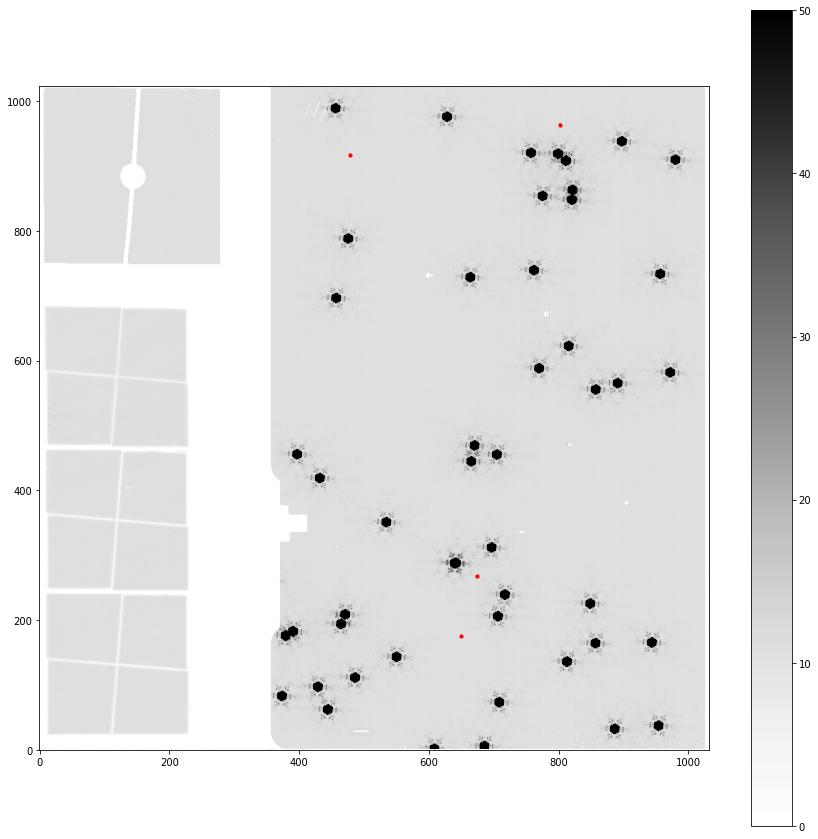

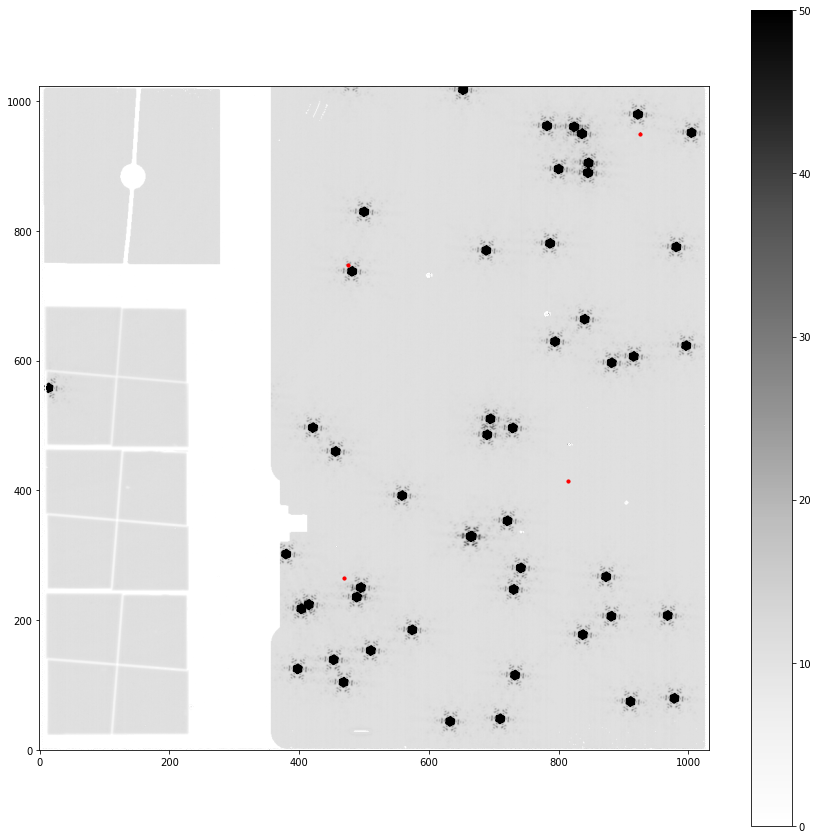

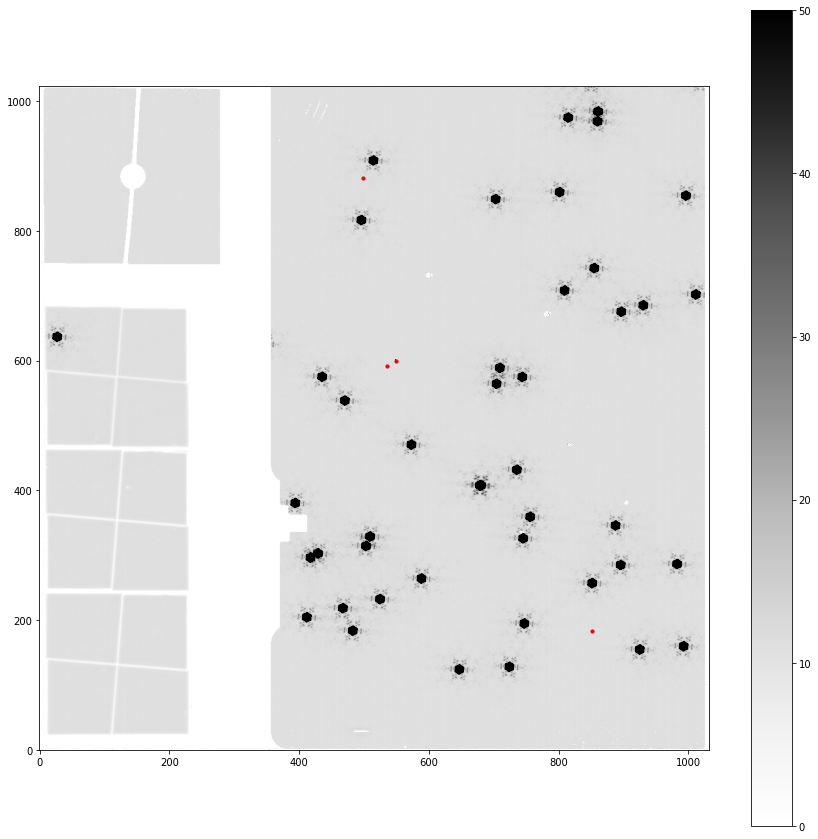

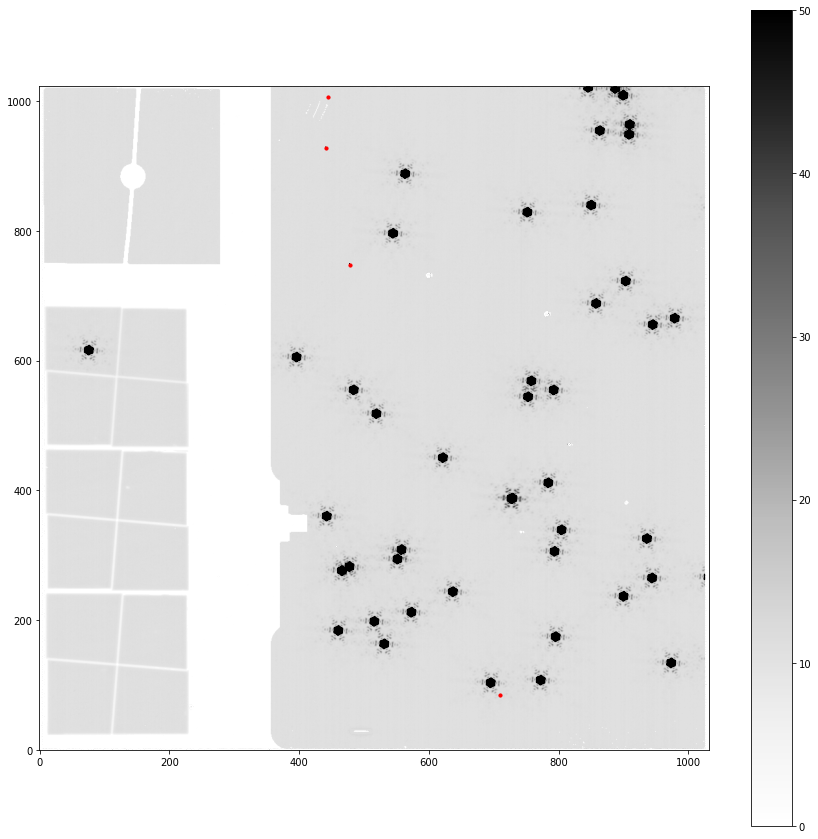

In [12]:
# Look at the images with outliers added to see if any landed on sources or might be less likely to be detected
i = 0
for image in cal_files:
    imagetest = ImageModel(image) 
    print(imagetest.meta.filename)
    print('Min value ', np.nanmin(imagetest.data), 'Max value ', np.nanmax(imagetest.data))
    j = 4*i
    crs = pixloc2[j:j+4]
    print(crs)
    yvals = pixloc2[j:j+4,0]
    xvals = pixloc2[j:j+4,1]

    plt.figure(figsize=(15,15))
    plt.imshow(imagetest.data,cmap="Greys",origin='lower',vmin=0, vmax=50)
    plt.colorbar()
    plt.scatter(xvals, yvals,lw=1, s=10,color='red')
    i += 1 

### Run calwebb_image3 on the association table, setting any specific parameters.

In [13]:
# use association table created in previous step with calwebb_image3
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=3.762  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 100 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.source_catalog.kernel_fwhm = fwhm
pipe3.source_catalog.snr_threshold = snr
pipe3.skymatch.save_results = True
pipe3.outlier_detection.save_results = True
pipe3.resample.save_results = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3
pipe3.run('starfield_50star4ptdither_asnfile.json')    
print('Image 3 pipeline finished.')

2022-06-20 21:14:50,426 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-06-20 21:14:50,428 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-06-20 21:14:50,431 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-06-20 21:14:50,433 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-06-20 21:14:50,434 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-06-20 21:14:50,436 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:14:50,437 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-06-20 21:14:50,661 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_asnfile.json',).


2022-06-20 21:14:50,667 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'brightest'

2022-06-20 21:14:50,804 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-06-20 21:14:50,824 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-06-20 21:14:50,826 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-06-20 21:14:50,827 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:14:50,829 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-06-20 21:14:51,532 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-06-20 21:14:51,537 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 2.0, 'use2dhist': False, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2022-06-20 21:14:51,910 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:14:52,268 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:14:52,596 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:14:52,929 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:14:52,949 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:14:52,950 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 4.


2022-06-20 21:14:52,951 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-06-20 21:14:52,976 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:14:52,977 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:14:53,004 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:14:53,005 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:14:53,028 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:14:53,030 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:14:53,055 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:14:53,056 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:14:53,056 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:14:53,057 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:14:53,058 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-06-20 21:14:53.057480


2022-06-20 21:14:53,058 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.4


2022-06-20 21:14:53,059 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:14:53,150 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2022-06-20 21:14:53,156 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:14:53,277 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:14:53,280 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:14:53,281 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:14:53,283 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:14:53,284 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000161021  YSH: -0.000340394


2022-06-20 21:14:53,285 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:14:53,286 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00458403   FIT MAE: 0.00386514


2022-06-20 21:14:53,286 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2022-06-20 21:14:53,329 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:14:53,451 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:14:53,453 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:14:53,454 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:14:53,456 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:14:53,457 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000162423  YSH: 0.00094112


2022-06-20 21:14:53,457 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:14:53,458 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00712559   FIT MAE: 0.00615171


2022-06-20 21:14:53,458 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2022-06-20 21:14:53,498 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:14:53,620 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:14:53,622 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:14:53,623 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:14:53,626 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:14:53,627 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000104823  YSH: 0.00255829


2022-06-20 21:14:53,627 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:14:53,628 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0111291   FIT MAE: 0.00662568


2022-06-20 21:14:53,629 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2022-06-20 21:14:53,669 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:14:53,670 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-06-20 21:14:53.669313


2022-06-20 21:14:53,670 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.611833


2022-06-20 21:14:53,671 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:14:53,876 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-06-20 21:14:54,087 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-06-20 21:14:54,089 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-06-20 21:14:54,221 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:14:54,222 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-06-20 21:14:54.221499


2022-06-20 21:14:54,223 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:14:54,223 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-06-20 21:14:54,224 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-06-20 21:14:54,224 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-06-20 21:14:54,225 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:14:54,226 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-06-20 21:14:57,206 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00471053


2022-06-20 21:14:57,207 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0123983


2022-06-20 21:14:57,208 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00106289


2022-06-20 21:14:57,209 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2022-06-20 21:14:57,210 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:14:57,210 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-06-20 21:14:57.209992


2022-06-20 21:14:57,211 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:02.988493


2022-06-20 21:14:57,211 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:14:57,493 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_0_skymatch.fits


2022-06-20 21:14:57,787 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_1_skymatch.fits


2022-06-20 21:14:58,088 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_2_skymatch.fits


2022-06-20 21:14:58,385 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_3_skymatch.fits


2022-06-20 21:14:58,386 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-06-20 21:14:58,567 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-06-20 21:14:58,569 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-06-20 21:14:58,576 - stpipe.Image3Pipeline.outlier_detection - INFO - Performing outlier detection on 4 inputs


2022-06-20 21:14:59,388 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:00,666 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:01,855 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:03,029 - stpipe.Image3Pipeline.outlier_detection - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:03,753 - stpipe.Image3Pipeline.outlier_detection - INFO - Generating median from 4 images


2022-06-20 21:15:04,387 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting median...


2022-06-20 21:15:05,243 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-06-20 21:15:06,568 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-06-20 21:15:07,607 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-06-20 21:15:08,592 - stpipe.Image3Pipeline.outlier_detection - INFO - Blotting (1024, 1032) <-- (1142, 1118)


2022-06-20 21:15:08,616 - stpipe.Image3Pipeline.outlier_detection - INFO - Flagging outliers


2022-06-20 21:15:08,708 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/jwst/outlier_detection/outlier_detection.py:418: RuntimeWarning: overflow encountered in multiply
  threshold1 = scale1 * blot_deriv + snr1 * err_data



2022-06-20 21:15:08,731 - stpipe.Image3Pipeline.outlier_detection - WARNING - /internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/miniconda3/envs/jwst_validation_notebooks/lib/python3.10/site-packages/jwst/outlier_detection/outlier_detection.py:427: RuntimeWarning: overflow encountered in multiply
  threshold2 = scale2 * blot_deriv + snr2 * err_data



2022-06-20 21:15:08,752 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 420 (0.04%)


2022-06-20 21:15:08,849 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 406 (0.04%)


2022-06-20 21:15:08,944 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 345 (0.03%)


2022-06-20 21:15:09,037 - stpipe.Image3Pipeline.outlier_detection - INFO - New pixels flagged as outliers: 337 (0.03%)


2022-06-20 21:15:09,309 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_0_a3001_crf.fits


2022-06-20 21:15:09,601 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_1_a3001_crf.fits


2022-06-20 21:15:09,898 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_2_a3001_crf.fits


2022-06-20 21:15:10,189 - stpipe.Image3Pipeline.outlier_detection - INFO - Saved model in starfield_50star4ptdither_combined_3_a3001_crf.fits


2022-06-20 21:15:10,190 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-06-20 21:15:10,434 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-06-20 21:15:10,436 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:15:10,460 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:15:10,643 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined.fits


2022-06-20 21:15:11,399 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-06-20 21:15:12,109 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:13,358 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:14,584 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:15,819 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:16,190 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:15:16,814 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:18,280 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:19,446 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:20,701 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:21,066 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:15:21,692 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:22,904 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:24,096 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:25,287 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:25,675 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:15:26,426 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:27,695 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:29,039 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:30,305 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:30,706 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021880561 -0.020262622 0.024954010 0.014760052 359.990667362 0.017768911 359.987593913 -0.017253764


2022-06-20 21:15:31,177 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_i2d.fits


2022-06-20 21:15:31,178 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-06-20 21:15:31,412 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1118) from starfield_50star4ptdither_combined_i2d.fits>,).


2022-06-20 21:15:31,415 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-06-20 21:15:31,440 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-06-20 21:15:31,460 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-06-20 21:15:31,461 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-06-20 21:15:31,462 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-06-20 21:15:31,463 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2022-06-20 21:15:31,464 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-06-20 21:15:31,546 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2022-06-20 21:15:32,461 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 45 sources


2022-06-20 21:15:32,614 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_cat.ecsv


2022-06-20 21:15:32,741 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_segm.fits


2022-06-20 21:15:32,743 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_segm.fits


2022-06-20 21:15:32,744 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-06-20 21:15:32,746 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


<a id="testing"></a>
# Perform Tests or Visualization

View the image and check number of pixels being flagged as outliers. 

[Top of Page](#title_ID)

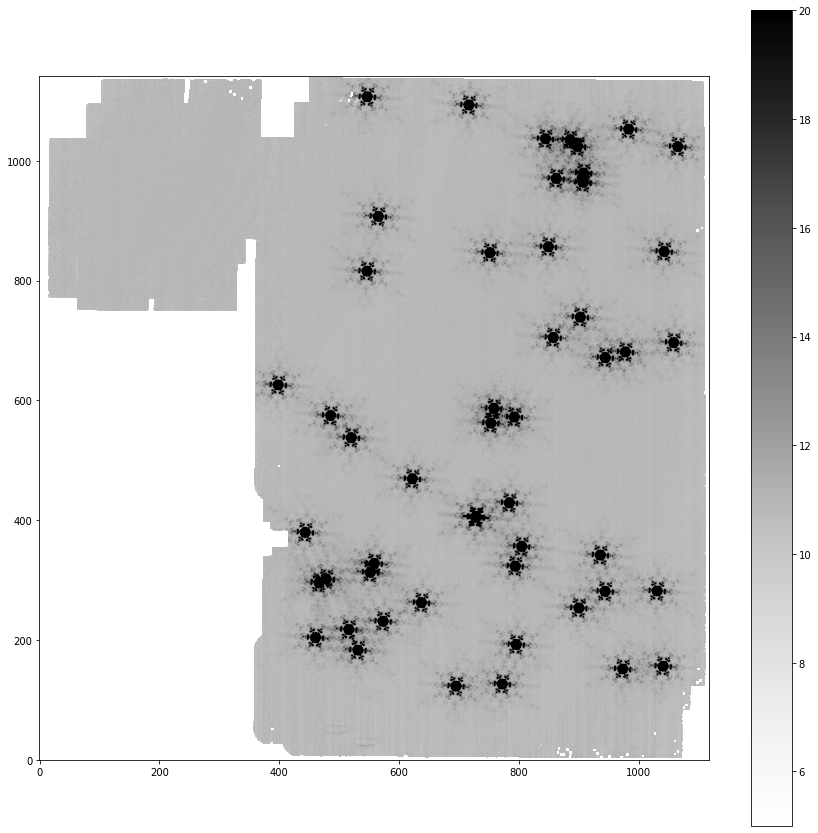

In [14]:
# read in i2d file

im_i2d = ImageModel('starfield_50star4ptdither_combined_i2d.fits')

#norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
#                      stretch=LinearStretch())

# mask out DO_NOT_USE values where data has been set to 0 in the combined image
masked_im = np.ma.masked_where((im_i2d.data == 0), im_i2d.data)

cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white') # color to mark all DO_NOT_USE pixels

plt.figure(figsize=(15,15))
#plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-5, vmax=4)
plt.imshow(masked_im, origin='lower', cmap = cmap, vmin=5, vmax=20)
plt.colorbar()

### Image examination
The image output should have the Four Quadrant phase masks on the left of the image masked out (values of 0). The image area should be smooth in the background regions with multiple point sources bright against the background. Passing criteria for the Lyot mask region are still being determined.

## Check output of source catalog against image

In [15]:
photfile = 'starfield_50star4ptdither_combined_cat.ecsv'
data = table.Table.read(photfile, format='ascii', comment='#')
print(len(data),' sources detected')

45  sources detected


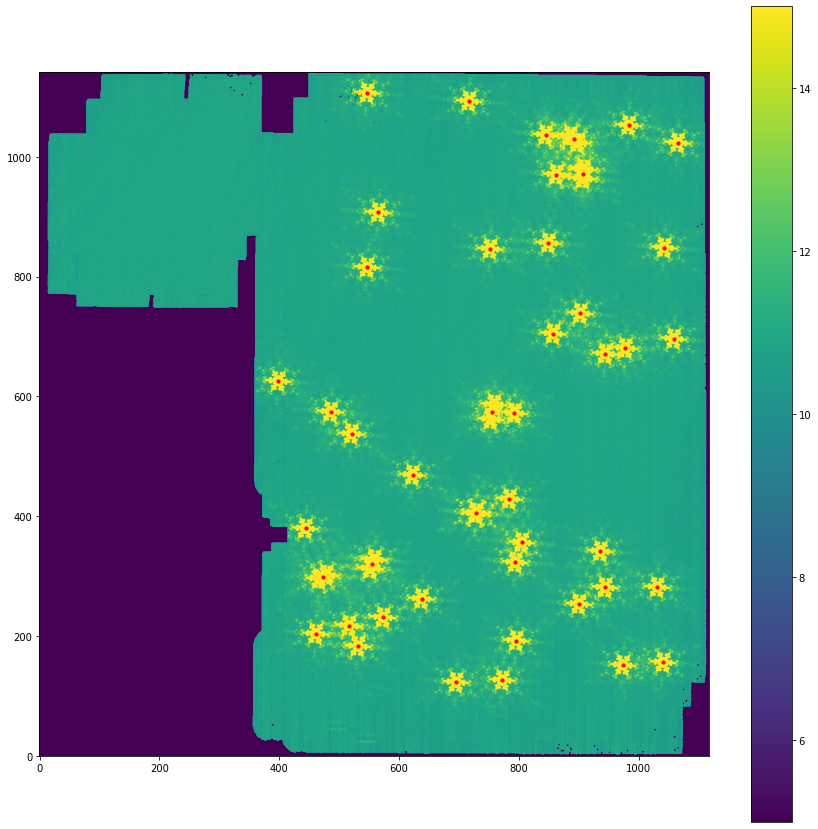

In [16]:
# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval
from astropy import table
from matplotlib.colors import LogNorm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)

norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
                      stretch=SqrtStretch())

plt.figure(figsize=(15,15))
#plt.imshow(viz2(im_i2d.data),cmap='gray')
plt.imshow(im_i2d.data,origin='lower', vmin=5, vmax=15)
plt.colorbar()
plt.scatter(data['xcentroid'], data['ycentroid'],lw=1, s=10,color='red')



### Check over source catalog match
If the red dots marking sources found in image above are centered on the point sources, the test passes.

### Check DQ Flagging of outlier detection 
Read in the individual crf files which are output from outlier_detection and check the dq extension to see how many pixels out of each image are flagged as outliers.

In [17]:
import glob
image3crffiles = glob.glob('*crf.fits')
output_files = sorted(image3crffiles)
print(image3crffiles)
print()
print(output_files)

['starfield_50star4ptdither_combined_0_a3001_crf.fits', 'starfield_50star4ptdither_combined_1_a3001_crf.fits', 'starfield_50star4ptdither_combined_2_a3001_crf.fits', 'starfield_50star4ptdither_combined_3_a3001_crf.fits']

['starfield_50star4ptdither_combined_0_a3001_crf.fits', 'starfield_50star4ptdither_combined_1_a3001_crf.fits', 'starfield_50star4ptdither_combined_2_a3001_crf.fits', 'starfield_50star4ptdither_combined_3_a3001_crf.fits']


In [18]:
# Get the names of the crf files as output by calwebb_image3. 
# This handwritten list is based on the naming of the files as they appear at the time the code was written (May 2021).
# If the filename convention changes, this block will need to be updated.

#output_files = []
#counter = 0
#for item in cal_files:
#    name = 'starfield_50star4ptdither_combined'
#    crffile = name+"_"+str(counter)+"_a3001_crf.fits"
#    output_files.append(crffile)
#    counter +=1

In [19]:
# Print calfiles and output_files to see the mapping of the filenames
print(cal_files)
print()
print(output_files)

['starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits', 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits']

['starfield_50star4ptdither_combined_0_a3001_crf.fits', 'starfield_50star4ptdither_combined_1_a3001_crf.fits', 'starfield_50star4ptdither_combined_2_a3001_crf.fits', 'starfield_50star4ptdither_combined_3_a3001_crf.fits']


In [20]:
dq_after = []
all_out_dqs = []

for i in range(len(output_files)):
    with ImageModel(output_files[i]) as crf:
        j = 4*i
        dq_after.append([pixloc2[j,:],crf.dq[pixloc2[j,0],pixloc2[j,1]]])
        dq_after.append([pixloc2[j+1,:],crf.dq[pixloc2[j+1,0],pixloc2[j+1,1]]])
        dq_after.append([pixloc2[j+2,:],crf.dq[pixloc2[j+2,0],pixloc2[j+2,1]]])
        dq_after.append([pixloc2[j+3,:],crf.dq[pixloc2[j+3,0],pixloc2[j+3,1]]])
        
        all_out_dqs.append((crf.dq[pixloc2[j,0],pixloc2[j,1]] & dqflags.pixel['OUTLIER'] > 0))
        all_out_dqs.append((crf.dq[pixloc2[j+1,0],pixloc2[j+1,1]] & dqflags.pixel['OUTLIER'] > 0))
        all_out_dqs.append((crf.dq[pixloc2[j+2,0],pixloc2[j+2,1]] & dqflags.pixel['OUTLIER'] > 0))
        all_out_dqs.append((crf.dq[pixloc2[j+3,0],pixloc2[j+3,1]] & dqflags.pixel['OUTLIER'] > 0))

print(dq_after)
print()
print(all_out_dqs)

[[array([176, 650]), 17], [array([964, 802]), 17], [array([917, 478]), 17], [array([268, 674]), 17], [array([950, 926]), 17], [array([414, 815]), 17], [array([747, 476]), 17], [array([265, 469]), 17], [array([592, 536]), 17], [array([183, 851]), 17], [array([881, 498]), 17], [array([600, 549]), 17], [array([1006,  444]), 17], [array([928, 441]), 17], [array([748, 478]), 17], [array([ 84, 709]), 17]]

[True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]


In [21]:
# Read in each crf file output from outlier_detection and see percentage of pixels flagged as outlier

flag_thresh = 1.0  # Percentage above which user should be notified of high percentage of flagged pixels

for crffile in output_files: 
    file = ImageModel(crffile)
    nx = file.meta.subarray.xsize
    ny = file.meta.subarray.ysize
    filename = file.meta.filename
    print(filename)

    numpix = nx * ny
    
    # Test that all pixels flagged with OUTLIER are also flagged as DO_NOT_USE
    outlierarray = (file.dq & dqflags.pixel['OUTLIER'] > 0)
    badarray = (file.dq & dqflags.pixel['DO_NOT_USE'] > 0)
    try:
        assert outlierarray.all() == badarray.all()
    except:
        print('Pixels flagged as outliers and "DO_NOT_USE" do not match')
    
    # Count number of pixels flagged as OUTLIER
    jumpcount = (file.dq & dqflags.pixel['OUTLIER'] > 0).sum()
    print('There are ', jumpcount, ' pixels flagged as outliers.')
    
    percentflagged = (jumpcount / numpix) * 100.

    print('The percentage of pixels flagged is ', percentflagged)
    if percentflagged > flag_thresh:
        print('This percentage is higher than it should be. Review data through outlier step')
    print('\n')    


starfield_50star4ptdither_combined_0_a3001_crf.fits
There are  2701  pixels flagged as outliers.
The percentage of pixels flagged is  0.25559063105620156




starfield_50star4ptdither_combined_1_a3001_crf.fits
There are  3552  pixels flagged as outliers.
The percentage of pixels flagged is  0.33611918604651164




starfield_50star4ptdither_combined_2_a3001_crf.fits
There are  4077  pixels flagged as outliers.
The percentage of pixels flagged is  0.38579896438953487




starfield_50star4ptdither_combined_3_a3001_crf.fits
There are  4554  pixels flagged as outliers.
The percentage of pixels flagged is  0.4309365915697675




In [22]:
# Print out whether all of the added cr hits were flagged as outliers

print('Output DQ values: ', all_out_dqs)
try:
    assert np.alltrue(all_out_dqs) == True
    print('MIRI Outlier Detection test: Passed')
except:
    print('AssertionError: At least one cr hit was not flagged')


Output DQ values:  [True, True, True, True, True, True, True, True, True, True, True, True, True, True, True, True]
MIRI Outlier Detection test: Passed


The output above should show percentages below some chosen threshold. If the percentage of pixels flagged as outliers are above the set threshold, there will be error messages printed. If no error messages are printed, this test is presumed to pass.

### Look at what the combined image would look like if no outlier_detection was performed.

In [23]:
asn = asn_from_list.asn_from_list(cal_files, rule=DMS_Level3_Base, product_name='starfield_50star4ptdither_combined_no_outlier.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('starfield_50star4ptdither_no_outlier_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])


In [24]:
# use association table created in previous step with calwebb_image3
    
# set any specific parameters
# tweakreg parameters to allow data to run
fwhm=3.762  # Gaussian kernel FWHM of objects expected, default=2.5
minobj=5  # minimum number of objects needed to match positions for a good fit, default=15
snr= 100 # signal to noise threshold, default=5
sigma= 3 # clipping limit, in sigma units, used when performing fit, default=3
fit_geom='shift' # ftype of affine transformation to be considered when fitting catalogs, default='general'
use2dhist=False  # boolean indicating whether to use 2D histogram to find initial offset, default=True

pipe3=Image3Pipeline()    
pipe3.tweakreg.kernel_fwhm = fwhm
pipe3.tweakreg.snr_threshold = snr
pipe3.tweakreg.minobj = minobj
pipe3.tweakreg.sigma = sigma
pipe3.tweakreg.fitgeometry = fit_geom
pipe3.tweakreg.use2dhist = use2dhist
pipe3.source_catalog.kernel_fwhm = fwhm
pipe3.source_catalog.snr_threshold = snr
pipe3.skymatch.save_results = True

pipe3.outlier_detection.skip = True

pipe3.resample.save_results = True
pipe3.source_catalog.save_results = True
pipe3.save_results = True

# run Image3
pipe3.run('starfield_50star4ptdither_no_outlier_asnfile.json')    
print('Image 3 pipeline finished.')

2022-06-20 21:15:35,459 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-06-20 21:15:35,461 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-06-20 21:15:35,463 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-06-20 21:15:35,465 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-06-20 21:15:35,467 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-06-20 21:15:35,469 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-06-20 21:15:35,470 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-06-20 21:15:35,718 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('starfield_50star4ptdither_no_outlier_asnfile.json',).


2022-06-20 21:15:35,725 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'brightest'

2022-06-20 21:15:35,867 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits' reftypes = ['abvegaoffset', 'apcorr', 'drizpars']


2022-06-20 21:15:35,871 - stpipe.Image3Pipeline - INFO - Prefetch for ABVEGAOFFSET reference file is '/grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf'.


2022-06-20 21:15:35,872 - stpipe.Image3Pipeline - INFO - Prefetch for APCORR reference file is '/grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits'.


2022-06-20 21:15:35,874 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits'.


2022-06-20 21:15:35,875 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-06-20 21:15:36,575 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-06-20 21:15:36,578 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'brightest': 200, 'peakmax': None, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 5, 'searchrad': 2.0, 'use2dhist': False, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'shift', 'nclip': 3, 'sigma': 3, 'align_to_gaia': False, 'gaia_catalog': 'GAIADR2', 'min_gaia': 5, 'save_gaia_catalog': False}


2022-06-20 21:15:36,896 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:15:37,257 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 48 sources in starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:15:37,569 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:15:37,889 - stpipe.Image3Pipeline.tweakreg - INFO - Detected 42 sources in starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits.


2022-06-20 21:15:37,909 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:15:37,910 - stpipe.Image3Pipeline.tweakreg - INFO - Number of image groups to be aligned: 4.


2022-06-20 21:15:37,911 - stpipe.Image3Pipeline.tweakreg - INFO - Image groups:


2022-06-20 21:15:37,938 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:15:37,939 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:15:37,964 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:15:37,965 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:15:37,990 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:15:37,991 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:15:38,020 - stpipe.Image3Pipeline.tweakreg - INFO - * Images in GROUP 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal':


2022-06-20 21:15:38,021 - stpipe.Image3Pipeline.tweakreg - INFO -      starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal


2022-06-20 21:15:38,022 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:15:38,022 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:15:38,023 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() started on 2022-06-20 21:15:38.022781


2022-06-20 21:15:38,023 - stpipe.Image3Pipeline.tweakreg - INFO -       Version 0.7.4


2022-06-20 21:15:38,023 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:15:38,110 - stpipe.Image3Pipeline.tweakreg - INFO - Selected image 'GROUP ID: starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' as reference image


2022-06-20 21:15:38,115 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:15:38,262 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:15:38,265 - stpipe.Image3Pipeline.tweakreg - INFO - Found 47 matches for 'GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:15:38,266 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:15:38,270 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:15:38,271 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000161021  YSH: -0.000340394


2022-06-20 21:15:38,272 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:15:38,273 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00458403   FIT MAE: 0.00386514


2022-06-20 21:15:38,274 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 46 objects.


2022-06-20 21:15:38,335 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:15:38,528 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:15:38,535 - stpipe.Image3Pipeline.tweakreg - INFO - Found 41 matches for 'GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:15:38,536 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:15:38,540 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:15:38,541 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000162423  YSH: 0.00094112


2022-06-20 21:15:38,541 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:15:38,542 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.00712559   FIT MAE: 0.00615171


2022-06-20 21:15:38,542 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 40 objects.


2022-06-20 21:15:38,585 - stpipe.Image3Pipeline.tweakreg - INFO - Aligning image catalog 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' to the reference catalog.


2022-06-20 21:15:38,707 - stpipe.Image3Pipeline.tweakreg - INFO - Matching sources from 'starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal' catalog with sources from the reference 'starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal' catalog.


2022-06-20 21:15:38,710 - stpipe.Image3Pipeline.tweakreg - INFO - Found 40 matches for 'GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal'...


2022-06-20 21:15:38,711 - stpipe.Image3Pipeline.tweakreg - INFO - Performing 'shift' fit


2022-06-20 21:15:38,714 - stpipe.Image3Pipeline.tweakreg - INFO - Computed 'shift' fit for GROUP ID: starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal:


2022-06-20 21:15:38,714 - stpipe.Image3Pipeline.tweakreg - INFO - XSH: -0.000104823  YSH: 0.00255829


2022-06-20 21:15:38,715 - stpipe.Image3Pipeline.tweakreg - INFO - 


2022-06-20 21:15:38,715 - stpipe.Image3Pipeline.tweakreg - INFO - FIT RMSE: 0.0111291   FIT MAE: 0.00662568


2022-06-20 21:15:38,716 - stpipe.Image3Pipeline.tweakreg - INFO - Final solution based on 39 objects.


2022-06-20 21:15:38,759 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:15:38,760 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() ended on 2022-06-20 21:15:38.759075


2022-06-20 21:15:38,760 - stpipe.Image3Pipeline.tweakreg - INFO - ***** tweakwcs.imalign.align_wcs() TOTAL RUN TIME: 0:00:00.736294


2022-06-20 21:15:38,761 - stpipe.Image3Pipeline.tweakreg - INFO -  


2022-06-20 21:15:38,975 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-06-20 21:15:39,230 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-06-20 21:15:39,232 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'match', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-06-20 21:15:39,375 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:15:39,376 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-06-20 21:15:39.375001


2022-06-20 21:15:39,376 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:15:39,377 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'match'


2022-06-20 21:15:39,377 - stpipe.Image3Pipeline.skymatch - INFO - Sky matching direction: DOWN


2022-06-20 21:15:39,378 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-06-20 21:15:39,378 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:15:39,380 - stpipe.Image3Pipeline.skymatch - INFO - ----  Computing differences in sky values in overlapping regions.


2022-06-20 21:15:42,250 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq1_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00471053


2022-06-20 21:15:42,252 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq2_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.0123983


2022-06-20 21:15:42,253 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq3_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0.00106289


2022-06-20 21:15:42,254 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=starfield_50star4ptdither_seq4_MIRIMAGE_F1130Wexp1_cal.fits. Sky background: 0


2022-06-20 21:15:42,257 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:15:42,258 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-06-20 21:15:42.257295


2022-06-20 21:15:42,259 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:02.882294


2022-06-20 21:15:42,260 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-06-20 21:15:42,552 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_0_skymatch.fits


2022-06-20 21:15:42,847 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_1_skymatch.fits


2022-06-20 21:15:43,145 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_2_skymatch.fits


2022-06-20 21:15:43,443 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_3_skymatch.fits


2022-06-20 21:15:43,444 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-06-20 21:15:43,674 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-06-20 21:15:43,676 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None}


2022-06-20 21:15:43,677 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2022-06-20 21:15:43,683 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-06-20 21:15:43,882 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-06-20 21:15:43,884 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None}


2022-06-20 21:15:43,902 - stpipe.Image3Pipeline.resample - INFO - Drizpars reference file: /grp/crds/cache/references/jwst/jwst_miri_drizpars_0001.fits


2022-06-20 21:15:44,068 - stpipe.Image3Pipeline.resample - INFO - Blending metadata for starfield_50star4ptdither_combined_no_outlier.fits


2022-06-20 21:15:44,769 - stpipe.Image3Pipeline.resample - INFO - Resampling science data


2022-06-20 21:15:45,471 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:46,918 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:48,210 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:49,432 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:49,865 - stpipe.Image3Pipeline.resample - INFO - Resampling var_rnoise


2022-06-20 21:15:50,510 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:51,751 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:53,109 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:54,364 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:54,873 - stpipe.Image3Pipeline.resample - INFO - Resampling var_poisson


2022-06-20 21:15:55,545 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:56,795 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:58,007 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:59,383 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:15:59,743 - stpipe.Image3Pipeline.resample - INFO - Resampling var_flat


2022-06-20 21:16:00,415 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:16:01,749 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:16:03,006 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:16:04,316 - stpipe.Image3Pipeline.resample - INFO - Drizzling (1024, 1032) --> (1142, 1118)


2022-06-20 21:16:04,860 - stpipe.Image3Pipeline.resample - INFO - Update S_REGION to POLYGON ICRS  0.021880561 -0.020262622 0.024954010 0.014760052 359.990667362 0.017768911 359.987593913 -0.017253764


2022-06-20 21:16:05,319 - stpipe.Image3Pipeline.resample - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_i2d.fits


2022-06-20 21:16:05,320 - stpipe.Image3Pipeline.resample - INFO - Step resample done


2022-06-20 21:16:05,595 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog running with args (<ImageModel(1142, 1118) from starfield_50star4ptdither_combined_no_outlier_i2d.fits>,).


2022-06-20 21:16:05,598 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'cat', 'search_output_file': True, 'input_dir': '', 'bkg_boxsize': 100, 'kernel_fwhm': 3.762, 'snr_threshold': 100, 'npixels': 5, 'deblend': False, 'aperture_ee1': 30, 'aperture_ee2': 50, 'aperture_ee3': 70, 'ci1_star_threshold': 2.0, 'ci2_star_threshold': 1.8}


2022-06-20 21:16:05,618 - stpipe.Image3Pipeline.source_catalog - INFO - Using APCORR reference file: /grp/crds/cache/references/jwst/jwst_miri_apcorr_0005.fits


2022-06-20 21:16:05,629 - stpipe.Image3Pipeline.source_catalog - INFO - Using ABVEGAOFFSET reference file: /grp/crds/cache/references/jwst/jwst_miri_abvegaoffset_0001.asdf


2022-06-20 21:16:05,631 - stpipe.Image3Pipeline.source_catalog - INFO - Instrument: MIRI


2022-06-20 21:16:05,631 - stpipe.Image3Pipeline.source_catalog - INFO - Detector: MIRIMAGE


2022-06-20 21:16:05,632 - stpipe.Image3Pipeline.source_catalog - INFO - Filter: F1130W


2022-06-20 21:16:05,633 - stpipe.Image3Pipeline.source_catalog - INFO - Subarray: FULL


2022-06-20 21:16:05,687 - stpipe.Image3Pipeline.source_catalog - INFO - AB to Vega magnitude offset 5.49349


2022-06-20 21:16:06,604 - stpipe.Image3Pipeline.source_catalog - INFO - Detected 45 sources


2022-06-20 21:16:06,757 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote source catalog: starfield_50star4ptdither_combined_no_outlier_cat.ecsv


2022-06-20 21:16:06,879 - stpipe.Image3Pipeline.source_catalog - INFO - Saved model in starfield_50star4ptdither_combined_no_outlier_segm.fits


2022-06-20 21:16:06,881 - stpipe.Image3Pipeline.source_catalog - INFO - Wrote segmentation map: starfield_50star4ptdither_combined_no_outlier_segm.fits


2022-06-20 21:16:06,882 - stpipe.Image3Pipeline.source_catalog - INFO - Step source_catalog done


2022-06-20 21:16:06,884 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline done


Image 3 pipeline finished.


### Look at combined image with and without outlier detection to see if the added cosmic rays show up in the final image without outlier detection

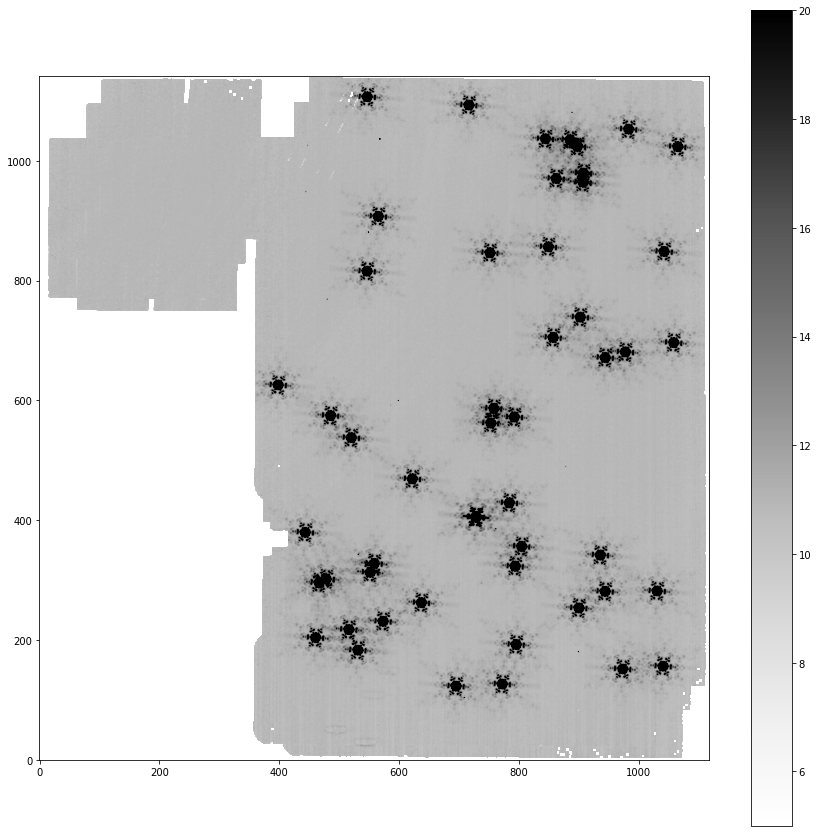

In [25]:
# read in i2d file without outlier_detection run.

im_i2d2 = ImageModel('starfield_50star4ptdither_combined_no_outlier_i2d.fits')

#norm = ImageNormalize(im_i2d2.data, interval=MinMaxInterval(),
#                      stretch=LinearStretch())

# mask out DO_NOT_USE values where data has been set to 0 in the combined image
masked_im2 = np.ma.masked_where((im_i2d2.data == 0), im_i2d2.data)

cmap = matplotlib.cm.get_cmap("Greys").copy()  # Can be any colormap that you want after the cm
cmap.set_bad(color='white') # color to mark all DO_NOT_USE pixels

plt.figure(figsize=(15,15))
#plt.imshow(im_i2d2.data,origin='lower',norm=norm,vmin=-5, vmax=4)
plt.imshow(masked_im2, origin='lower', cmap = cmap, vmin=5, vmax=20)
plt.colorbar()

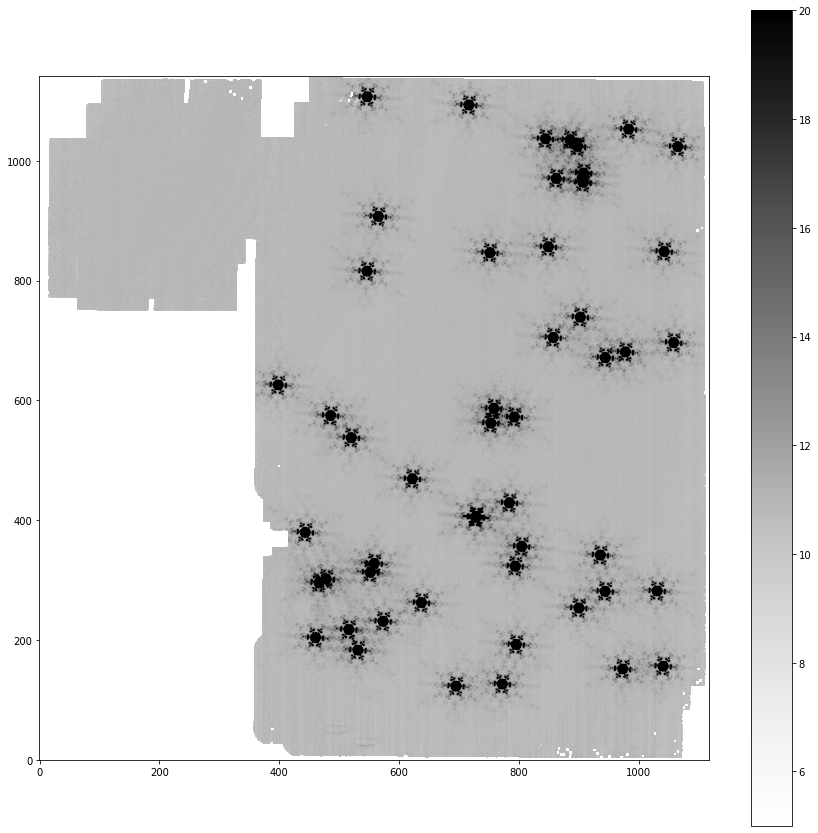

In [26]:
# Compare to image with outlier_detection run

#norm = ImageNormalize(im_i2d.data, interval=MinMaxInterval(),
#                      stretch=LinearStretch())

plt.figure(figsize=(15,15))
#plt.imshow(im_i2d.data,origin='lower',norm=norm,vmin=-5, vmax=4)
plt.imshow(masked_im, origin='lower', cmap = cmap, vmin=5, vmax=20)
plt.colorbar()

## Passing criteria

If the inserted cosmic rays were flagged by the outlier_detection step (no AssertionError) and the outlier_detection run version of the combined image appears cleaner with fewer to no cosmic rays showing, the test passes. If there are only one or two sources that were not properly flagged, they could have been located on a source or been otherwise difficult to detect. Check the locations of the outliers as shown in earlier parts of the notebook to see if any outliers might be likely to fail to be detected.

<a id="about_ID"></a>
## About this Notebook
**Author:** Misty Cracraft, Senior Staff Scientist, MIRI Branch
<br>**Updated On:** 02/17/2021

[Top of Page](#title_ID)
<img style="float: right;" src="./stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="stsci_pri_combo_mark_horizonal_white_bkgd" width="200px"/> 